In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

%matplotlib inline

# The call center's call volume is bimodal, rather than the traditionally expected Poisson distribution.

### Since the "natural" distribution would be expected to be Poisson, a starting assumption could be that the bimodal distribution is composed of one Poisson distribution commbined with another unknown distribution

In [2]:
## HELPER FUNCTIONS - NOT INTERESTING.
## Skip ahead unless you really like reading code


# Made-up values for various situations. I'm using very large numbers so graphs clearly show differences in distributions
OVERDUE_MU = 6
CANCELLATION_MU = 8
RENEGOTIATION_MU = 10
NORMAL_MU = 1/10

# Functions for generating samples from various Poisson distributions
def adjust_overdue_mu(df):
    """Adjust the mu to account for various factors that may increase the probability of calls"""
    return mu_adjustments(df, OVERDUE_MU, 'overdue_loan')

def adjust_cancellation_mu(df):
    """Adjust the mu to account for various factors that may increase the probability of calls"""
    return mu_adjustments(df, CANCELLATION_MU, 'cancellation_status')

def adjust_renegotiation_mu(df):
    """Adjust the mu to account for various factors that may increase the probability of calls"""
    return mu_adjustments(df, RENEGOTIATION_MU, 'being_renegotiated')

def adjust_normal_mu(df):
    """Adjust the mu to account for various factors that may increase the probability of calls"""
    return mu_adjustments(df, NORMAL_MU, '', test_condition=False)

def mu_adjustments(df, default_mu, condition, test_condition=True):
    # If the condition doesn't apply, then there won't be any calls of that type:
    if test_condition:
        default_mu *= df[condition]   # The value is 1 when true, 0 when false

    # Mondays and Fridays get more calls than Tue-Thu
    if df.monday:
        default_mu *= 1.5
    elif df.friday:
        default_mu *= 1.3

    # Small loans are much more likely to get 'overdue' and 'cancellation' calls
    if condition == 'overdue_loan' or condition == 'cancellation_status':
        if df.log_loan_amount < 3:
            default_mu *= 4

    # Large loans are much more likely to be renegotiated:
    if condition == 'being_renegotiated':
        if df.log_loan_amount > 7:
            default_mu *= 4

    return np.random.poisson(default_mu)

In [3]:
# Create a dataframe with call volume based on a Poisson distribution
# For simplicity, we'll ignore time effects

# Each account's number of expected calls is:
samples = 10000
call_df = pd.DataFrame({'log_loan_amount': np.random.lognormal(1.5, .5, samples),
                           'weekday': np.random.randint(0, 5, samples), # 0 is Monday, 4 is Friday
                           'overdue_loan': np.random.choice([1, 0], samples, p=[.05, .95]),
                           'cancellation_status': np.random.choice([1, 0], samples, p=[.01, .99]),
                           'being_renegotiated': np.random.choice([1, 0], samples, p=[.03, .97])})

# Add variables for whether the day is Friday or Monday
call_df['monday'] = 0
call_df['friday'] = 0
call_df.loc[call_df['weekday'] == 0, 'monday'] = 1
call_df.loc[call_df['weekday'] == 4, 'friday'] = 1

# Generate samples from various Poisson distributions, depending on the account's characteristics
call_df['overdue_calls'] = call_df.apply(adjust_overdue_mu, axis=1)
call_df['cancellation_calls'] = call_df.apply(adjust_cancellation_mu, axis=1)
call_df['renegotiation_calls'] = call_df.apply(adjust_renegotiation_mu, axis=1)
call_df['normal_calls'] = call_df.apply(adjust_normal_mu, axis=1)
call_df['total_calls'] = call_df[['overdue_calls', 'cancellation_calls', 'renegotiation_calls', 'normal_calls']].max(axis=1)

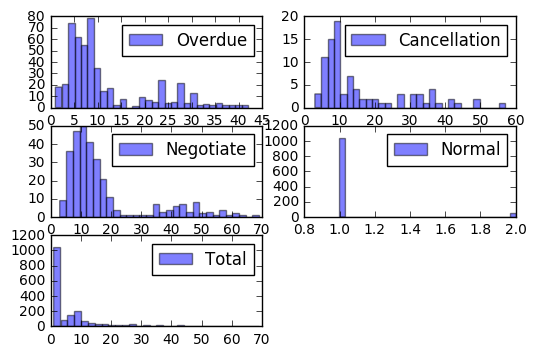

In [4]:
# Graph the distributions
def return_nonzero_values(df, criteria):
    """Used for legibility"""
    return df.iloc[df[criteria].nonzero()][criteria].tolist()

## Only graph values > 0
plt.subplot(3, 2, 1)
plt.hist(return_nonzero_values(call_df, 'overdue_calls'), 30, label="Overdue", alpha=.5)
plt.legend(loc='upper right')
plt.subplot(3, 2, 2)
plt.hist(return_nonzero_values(call_df, 'cancellation_calls'), 30, label="Cancellation", alpha=.5)
plt.legend(loc='upper right')
plt.subplot(3, 2, 3)
plt.hist(return_nonzero_values(call_df, 'renegotiation_calls'), 30, label="Negotiate", alpha=.5)
plt.legend(loc='upper right')
plt.subplot(3, 2, 4)
plt.hist(return_nonzero_values(call_df, 'normal_calls'), 30, label="Normal", alpha=.5)
plt.legend(loc='upper right')
plt.subplot(3, 2, 5)
plt.hist(return_nonzero_values(call_df, 'total_calls'), 30, label="Total", alpha=.5)
plt.legend(loc='upper right')

plt.show()

# Now we make the regression model that assumes the data has a Poisson distribution

In [5]:
train, test = train_test_split(call_df, test_size=.2)
train_y = train.total_calls
train_x = train.loc[:, train.columns.isin(['monday', 'friday', 'log_loan_amount'])]
# This model likes a constant:
train_x = sm.add_constant(train_x, prepend=False)

poisson_model = sm.Poisson(train_y, train_x)
poisson_fit = poisson_model.fit(method='newton')
print(poisson_fit.summary())

Optimization terminated successfully.
         Current function value: 3.481204
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:            total_calls   No. Observations:                 8000
Model:                        Poisson   Df Residuals:                     7996
Method:                           MLE   Df Model:                            3
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                0.003014
Time:                        07:20:20   Log-Likelihood:                -27850.
converged:                       True   LL-Null:                       -27934.
                                        LLR p-value:                 2.832e-36
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_loan_amount    -0.0054      0.004     -1.507      0.132      -0.012       0.002
monday        

The model's predictions:
count    2000.000000
mean        1.313216
std         0.166251
min         1.073789
25%         1.186318
50%         1.201165
75%         1.500692
max         1.593025
dtype: float64


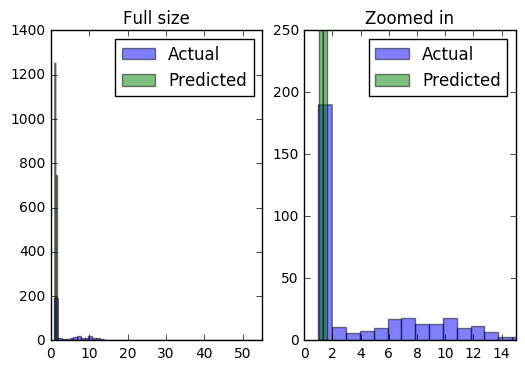

In [6]:
# Calculate and graph actual vs predicted values
test_y = test.total_calls
test_x = test.loc[:, test.columns.isin(['monday', 'friday', 'log_loan_amount'])]
# Add a constant:
test_x = sm.add_constant(test_x, prepend=False)
test_predictions = poisson_fit.predict(test_x)
print("The model's predictions:")
print(test_predictions.describe())

# Graph the results, removing 0s for readability
plt.subplot(1, 2, 1)
plt.hist(return_nonzero_values(test, 'total_calls'), max(test.total_calls), label="Actual", alpha=.5)
# The predictions are continuous, so removing 0s doesn't make sense. Instead, remove #s < .5
nonzero_predictions = [item for item in test_predictions.tolist() if item >= .5]
plt.hist(nonzero_predictions, int(round(max(nonzero_predictions))), label="Predicted", alpha=.5)
plt.legend(loc='upper right')
plt.xlim(0, max(max(test.total_calls), int(round(max(nonzero_predictions)))))
plt.title("Full size")

plt.subplot(1, 2, 2)
plt.title("Zoomed in")
plt.hist(return_nonzero_values(test, 'total_calls'), max(test.total_calls), label="Actual", alpha=.5)
plt.hist(nonzero_predictions, int(round(max(nonzero_predictions))), label="Predicted", alpha=.5)
plt.legend(loc='upper right')
plt.xlim(0, 15)
plt.ylim(0, 250)

plt.show()

# This simple model is terrible and sounds like the model you described to me. The explanatory variables are significant, but the model doesn't come close to fitting our distribution. Try to do better by including different kinds of information.

In [7]:
train_x = train.loc[:, train.columns.isin([
    'monday',
    'friday',
    'log_loan_amount',
    'overdue_loan',
    'cancellation_status',
    'being_renegotiated'])]

poisson_model_v2 = sm.Poisson(train_y, train_x)
poisson_fit_v2 = poisson_model_v2.fit(method='newton')
print(poisson_fit_v2.summary())

Optimization terminated successfully.
         Current function value: 1.452634
         Iterations 31
                          Poisson Regression Results                          
Dep. Variable:            total_calls   No. Observations:                 8000
Model:                        Poisson   Df Residuals:                     7994
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                  0.5840
Time:                        07:20:21   Log-Likelihood:                -11621.
converged:                       True   LL-Null:                       -27934.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
being_renegotiated      2.9244      0.018    159.261      0.000       2.888       2.960
c

The model's predictions:
count    2000.000000
mean        1.401628
std         3.179680
min         0.085687
25%         0.503470
50%         0.627695
75%         0.742961
max        87.708699
dtype: float64


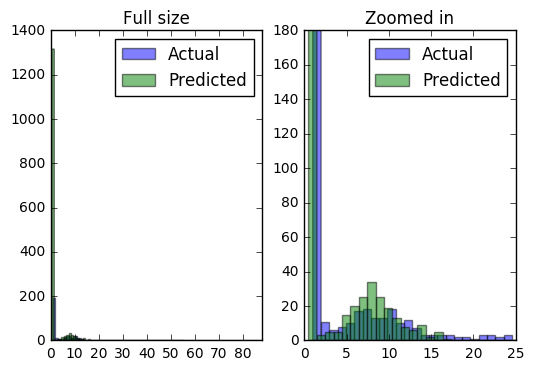

In [8]:
# Calculate and graph actual vs predicted values
test_y = test.total_calls
test_x = test.loc[:, test.columns.isin([
    'monday',
    'friday',
    'log_loan_amount',
    'overdue_loan',
    'cancellation_status',
    'being_renegotiated'])]
test_predictions = poisson_fit_v2.predict(test_x)
print("The model's predictions:")
print(test_predictions.describe())

# Graph the results, removing 0s for readability
plt.subplot(1, 2, 1)
plt.hist(return_nonzero_values(test, 'total_calls'), max(test.total_calls), label="Actual", alpha=.5)
# The predictions are continuous, so removing 0s doesn't make sense. Instead, remove #s < .5
nonzero_predictions = [item for item in test_predictions.tolist() if item >= .5]
plt.hist(nonzero_predictions, int(round(max(nonzero_predictions))), label="Predicted", alpha=.5)
plt.legend(loc='upper right')
plt.xlim(0, max(max(test.total_calls), int(round(max(nonzero_predictions)))))
plt.title("Full size")

plt.subplot(1, 2, 2)
plt.title("Zoomed in")
plt.hist(return_nonzero_values(test, 'total_calls'), max(test.total_calls), label="Actual", alpha=.5)
plt.hist(nonzero_predictions, int(round(max(nonzero_predictions))), label="Predicted", alpha=.5)
plt.legend(loc='upper right')
plt.xlim(0, 25)
plt.ylim(0, 180)

plt.show()

# Your question: what to do next?

#### A Poisson estimator can capture more than one hump in a bimodal distribution. The second estimator even did a decent job. But in order for it to be possible, you have to be modeling the variables that have caused both humps of the distribution.

#### Since this is an internal model for the call center, a next step could be to try a more opaque model, like random forests or gradient tree boosting, to see if they can capture the subtlety around 'log_loan_amount' or how probabilities aren't added linearly to create 'total_calls'.

#### The best solution would be to speak with the client to better understand the problem. That a distribution is bimodal should normally imply that there is more than one process going on at a time, and you would be better able to model the entire situation by breaking out all the different processes and modeling them individually.

#### For the call center example that MountainView experienced, I would suggest adding variables like days until late fees accrue, days until the account cancels (depending on what that means for their collateral), the average number of calls per payment for individual lenders, time until loan maturity, number of prior payments made, and so on. Then I'd try to break out processes based on what sequence of events had to occur before any call was made to the call center.

#### Finally, if you hit roadblocks there, then work on data transformations. Take the logs of dollar values, difference variables that change over time, and normalize or standardize unusual data.